In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf

np.random.seed(13)
tf.random.set_seed(13)

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from wordcloud import WordCloud
from xml.sax import ContentHandler, parse

from nltk import word_tokenize
import nltk

#nltk.download('punkt')

stemmer = SnowballStemmer('english', ignore_stopwords=True)
stop = set(stopwords.words('english'))

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

2023-05-19 15:45:38.844284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Class that hadles excel files

In [2]:
%%time

class ExcelHandler(ContentHandler):
    def __init__(self):
        self.chars = [  ]
        self.cells = [  ]
        self.rows = [  ]
        self.tables = [  ]
    def characters(self, content):
        self.chars.append(content)
    def startElement(self, name, atts):
        if name=="Cell":
            self.chars = [  ]
        elif name=="Row":
            self.cells=[  ]
        elif name=="Table":
            self.rows = [  ]
    def endElement(self, name):
        if name=="Cell":
            self.cells.append(''.join(self.chars))
        elif name=="Row":
            self.rows.append(self.cells)
        elif name=="Table":
            self.tables.append(self.rows)



CPU times: user 84 µs, sys: 6 µs, total: 90 µs
Wall time: 98.5 µs


In [3]:
excelHandler = ExcelHandler()
parse('data/features.xls', excelHandler)
features = pd.DataFrame(excelHandler.tables[0][1:], columns=excelHandler.tables[0][0])

Parse Excel file and create dataframe


In [4]:
y = np.where(features['Label'] == 'objective', 0, 1)

Create labels: objective = 0, subjective = 1

In [5]:
texts = []
normalized_texts = []

for i in range(1, 1001):
    if i // 10 == 0:
        num = '000' + str(i)
    elif i // 100 == 0:
        num = '00' + str(i)
    elif i // 1000 == 0:
        num = '0' + str(i)
    else:
        num = '1000'
    
    f = open('data/raw-data/Text' + num + '.txt', 'r', encoding='latin-1')
    text = f.read()
    
    # removes any non-alphabetic characters and tokenizes 
    # the text from the Natural Language Toolkit (nltk)
    
    normalized_text = ' '.join([stemmer.stem(w) for w in word_tokenize(text) if (w.isalpha() and w not in stop)])
    texts.append(text)
    normalized_texts.append(normalized_text)

Create two strings for the preprocessed texts: one for objective and one for subjective

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(normalized_texts), y, random_state=13, stratify=y)

Splits the data into training and testing sets for use in a machine learning model.

# Decision Tree's

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Create an instance of the TfidfVectorize

In [8]:
vectorizer = TfidfVectorizer()

Fit the vectorizer on the training data and transform the training data

In [9]:
X_train_vectorized = vectorizer.fit_transform(X_train)

Transform the test data

In [10]:
X_test_vectorized = vectorizer.transform(X_test)

Create an instance of the DecisionTreeClassifier

In [11]:
classifier = DecisionTreeClassifier()

Fit the model on the vectorized training data

In [12]:
classifier.fit(X_train_vectorized, y_train)

DecisionTreeClassifier()

Make predictions on the vectorized test data


In [13]:
%%time
y_pred = classifier.predict(X_test_vectorized)

CPU times: user 2.19 ms, sys: 58 µs, total: 2.25 ms
Wall time: 1.48 ms


Summary of the predictions made by the classifier

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       159
           1       0.64      0.68      0.66        91

    accuracy                           0.74       250
   macro avg       0.72      0.73      0.73       250
weighted avg       0.75      0.74      0.75       250



Precision, recall, and F1-score provide insights into the classifier's performance for each class individually.

    Class 0 (Objective):
        Precision: 81%
        This indicates that out of all the instances predicted as objective, 81% were correctly classified.
        Recall: 78%
        It means that out of all the actual objective instances, 78% were correctly identified by the classifier.
        F1-score: 79%
        The F1-score is the harmonic mean of precision and recall. In this case, it is 79% for class 0, which indicates a reasonable balance between precision and recall.

    Class 1 (Subjective):
        Precision: 64%
        This suggests that out of all the instances predicted as subjective, only 64% were actually subjective.
        Recall: 68%
        It means that out of all the actual subjective instances, 68% were correctly identified by the 
        classifier.
        F1-score: 66%
        The F1-score for class 1 is 66%, indicating a moderate balance between precision and recall.

Comparing the precision, recall, and F1-scores between the two classes, it is evident that the classifier performs better in identifying objective texts (class 0) compared to subjective texts (class 1). The lower performance on subjective texts might be due to the complexity and subjectivity inherent in identifying subjective language patterns.

#### Confusion matrix

In [15]:
print(confusion_matrix(y_test, y_pred))

[[124  35]
 [ 29  62]]


The confusion matrix provides a detailed breakdown of the classifier's performance in terms of true positives, true negatives, false positives, and false negatives.

    True Positives (TP): 124
    The classifier correctly classified 124 instances of class 0 (objective) as objective.

    True Negatives (TN): 62
    The classifier correctly classified 62 instances of class 1 (subjective) as subjective.

    False Positives (FP): 35
    The classifier incorrectly classified 35 instances of class 0 (objective) as subjective.

    False Negatives (FN): 29
    The classifier incorrectly classified 29 instances of class 1 (subjective) as objective.

The confusion matrix indicates that the classifier has a higher rate of misclassifying objective texts as subjective (false positives) compared to misclassifying subjective texts as objective (false negatives). This suggests a potential bias towards identifying texts as subjective.

#### Accuracy Score

In [16]:
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.744


This means that out of all the samples in the test set, the classifier correctly classified approximately 74.4% of them. 

# Support Vector Machine's (SVM) 

In [17]:
from sklearn.svm import SVC

Create an instance of the SVC (Support Vector Classifier)

In [18]:
classifier = SVC()

Fit the model on the vectorized training data

In [19]:
classifier.fit(X_train_vectorized, y_train)

SVC()

Make predictions on the vectorized test data

In [20]:
%%time
y_pred = classifier.predict(X_test_vectorized)

CPU times: user 344 ms, sys: 3.8 ms, total: 348 ms
Wall time: 348 ms


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       159
           1       0.81      0.51      0.62        91

    accuracy                           0.78       250
   macro avg       0.79      0.72      0.73       250
weighted avg       0.78      0.78      0.76       250



Precision, recall, and F1-score provide insights into the classifier's performance for each class individually.

    Class 0 (Objective):
        Precision: 77%
        Out of all the instances predicted as objective, 77% were correctly classified.
        Recall: 93%
        Among all the actual objective instances, 93% were correctly identified by the classifier.
        F1-score: 84%
        The F1-score for class 0 is 84%, which indicates a good balance between precision and recall.

    Class 1 (Subjective):
        Precision: 81%
        This suggests that out of all the instances predicted as subjective, 81% were actually subjective.
        Recall: 51%
        Among all the actual subjective instances, 51% were correctly identified by the classifier.
        F1-score: 62%
        The F1-score for class 1 is 62%, indicating a moderate balance between precision and recall.

Comparing the precision, recall, and F1-scores between the two classes, we can see that the classifier performs better in identifying objective texts (class 0) compared to subjective texts (class 1). However, the recall for class 1 is relatively low, indicating that the model struggles to correctly identify subjective texts.

#### Print the confusion matrix

In [22]:
print(confusion_matrix(y_test, y_pred))

[[148  11]
 [ 45  46]]


The confusion matrix provides insights into the classifier's performance in terms of true positives, true negatives, false positives, and false negatives.

    True Positives (TP): 148
    The classifier correctly classified 148 instances of class 0 (objective) as objective.

    True Negatives (TN): 46
    The classifier correctly classified 46 instances of class 1 (subjective) as subjective.

    False Positives (FP): 11
    The classifier incorrectly classified 11 instances of class 1 (subjective) as objective.

    False Negatives (FN): 45
    The classifier incorrectly classified 45 instances of class 0 (objective) as subjective.

The confusion matrix reveals that the classifier has a relatively higher rate of misclassifying subjective texts as objective (false negatives) compared to misclassifying objective texts as subjective (false positives).

#### Accuracy Score

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.776


This means that approximately 77.6% of the samples in the test set were correctly classified by the SVM model.

The SVM classifier achieved a reasonably good accuracy of 77.6% on the test set, suggesting that it can distinguish between objective and subjective texts with moderate success.

However, the model shows a notable difficulty in correctly identifying subjective texts, as reflected by the lower recall and F1-score for class 1.

The precision and F1-score for class 1 are relatively better, indicating that when the model predicts a text as subjective, it tends to be more accurate.

# K-Nearest Neighbours

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

Create an instance of the KNN:

In [25]:
# Define the parameter grid
# param_grid = {'n_neighbors': [3, 5, 7, 8, 9, 11]}

# Initialize the KNN classifier
classifier = KNeighborsClassifier()

# Perform grid search with cross-validation
#grid_search = GridSearchCV(classifier, param_grid, cv=6)

# Fit the grid search on the vectorized training data
#grid_search.fit(X_train_vectorized, y_train)

# Get the best parameter
#best_k = grid_search.best_params_['n_neighbors']

classifier = KNeighborsClassifier(n_neighbors=8)

Fit the model on the vectorized training data

In [26]:
classifier.fit(X_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=8)

Make predictions on the vectorized test data

In [27]:
%%time
y_pred = classifier.predict(X_test_vectorized)

CPU times: user 10.6 s, sys: 71.5 ms, total: 10.7 s
Wall time: 3 s


Summary of the predictions made by the classifier

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       159
           1       0.57      0.53      0.55        91

    accuracy                           0.68       250
   macro avg       0.66      0.65      0.65       250
weighted avg       0.68      0.68      0.68       250



Precision, recall, and F1-score provide insights into the classifier's performance for each class individually.
    
    Class 0 (Objective):
        Precision: 74%
        Out of all instances predicted as objective, 74% were correctly classified.
        Recall: 77%
        Among all actual objective instances, the KNN classifier identified 77% correctly.
        F1-Score: 76%
        The F1-score, a harmonic mean of precision and recall, is 76% for class 0. This indicates a reasonable balance between precision and recall.

    Class 1 (Subjective):
        Precision: 57%
        57% of the instances predicted as subjective were actually subjective.
        Recall: 53%
        The KNN model correctly identified 53% of the actual subjective instances.
        F1-Score: 55%
        The F1-score for class 1 is 55%, suggesting a moderate balance between precision and recall.

Comparing the precision, recall, and F1-scores between the two classes, the KNN classifier performs better in identifying objective texts (class 0) compared to subjective texts (class 1). However, the recall and F1-score for class 1 are relatively lower, indicating that the KNN model struggles to capture subjective instances effectively.

#### Print the confusion matrix

In [29]:
print(confusion_matrix(y_test, y_pred))

[[123  36]
 [ 43  48]]


The confusion matrix provides insights into the KNN classifier's performance in terms of true positives, true negatives, false positives, and false negatives.

    True Positives (TP): 123
    The classifier correctly classified 123 instances of class 0 (objective) as objective.

    True Negatives (TN): 48
    The classifier correctly classified 48 instances of class 1 (subjective) as subjective.

    False Positives (FP): 36
    The classifier incorrectly classified 36 instances of class 1 (subjective) as objective.

    False Negatives (FN): 43
    The classifier incorrectly classified 43 instances of class 0 (objective) as subjective.

The confusion matrix reveals that the KNN classifier has a higher rate of misclassifying subjective texts as objective (false negatives) compared to misclassifying objective texts as subjective (false positives).

#### Accuracy Score

In [30]:
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.684


This indicates that approximately 68.4% of the samples in the test set were correctly classified by the KNN model

In summary, the KNN classifier achieved a moderate accuracy but shows room for improvement, especially in correctly identifying subjective texts. It is worth noting that you have already explored various improvement techniques such as hyperparameter tuning, dimensional reduction, and ensemble methods like random forest. However, these attempts did not significantly improve the accuracy.

Further analysis, experimentation, and consideration of alternative approaches may be necessary to enhance the performance of the KNN classifier. It is important to thoroughly evaluate different algorithms, adjust hyperparameters, explore different feature engineering techniques, or consider alternative models to achieve better results. Additionally, taking into account the specific characteristics and nuances of the dataset and the objectives of the classification task is crucial.

# Visual Comparison between the previous algorithms

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder

Classifiers:

In [32]:
classifiers = [
    DecisionTreeClassifier(),
    SVC(),
    KNeighborsClassifier(n_neighbors=8),
]

Logging for Visual Comparison:

In [33]:
log_cols=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_vectorized, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test_vectorized)
    acc = accuracy_score(y_test, train_predictions)
    precision = precision_score(y_test, train_predictions)
    recall = recall_score(y_test, train_predictions)
    f1 = f1_score(y_test, train_predictions)
    
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(precision))
    print("Recall: {:.4%}".format(recall))
    print("F1-score: {:.4}".format(f1))
    log_entry = pd.DataFrame([[name, acc*100, precision*100, recall*100, f1]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)
    print("="*30)
    
    print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 72.8000%
Precision: 62.1053%
Recall: 64.8352%
F1-score: 0.6344
SVC
****Results****
Accuracy: 77.6000%
Precision: 80.7018%
Recall: 50.5495%
F1-score: 0.6216
KNeighborsClassifier
****Results****
Accuracy: 68.4000%
Precision: 57.1429%
Recall: 52.7473%
F1-score: 0.5486


Plotting Accuracy:

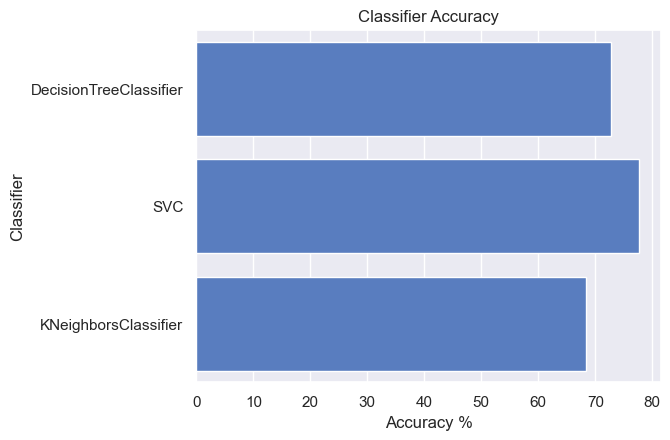

In [45]:
sns.set_color_codes("muted")

plt.subplot(2, 2, 2)
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')

plt.tight_layout()
plt.show()

Plotting Precision:

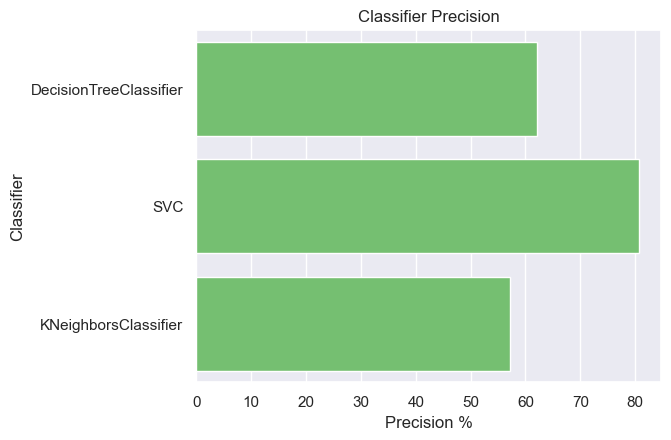

In [35]:
plt.subplot(2, 2, 2)
sns.barplot(x='Precision', y='Classifier', data=log, color="g")
plt.xlabel('Precision %')
plt.title('Classifier Precision')

plt.tight_layout()
plt.show()

Plotting F1-score:

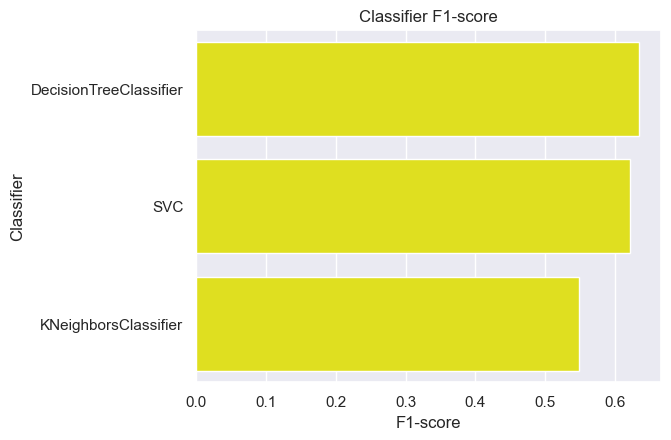

In [44]:
plt.subplot(2, 2, 2)
sns.barplot(x='F1-score', y='Classifier', data=log, color="yellow")
plt.xlabel('F1-score')
plt.title('Classifier F1-score')

plt.tight_layout()
plt.show()

Plotting Recall:

Text(0.5, 1.0, 'Classifier Recall')

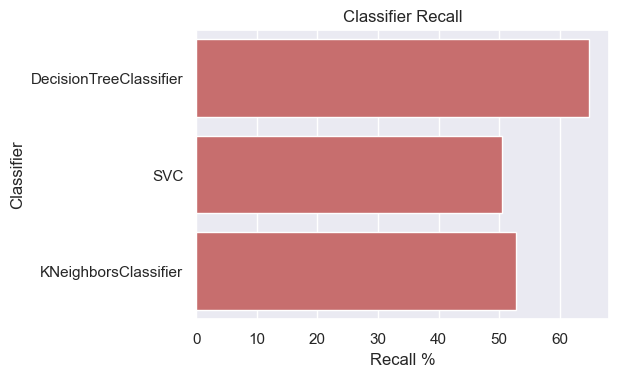

In [37]:
plt.subplot(2, 2, 3)
sns.barplot(x='Recall', y='Classifier', data=log, color="r")
plt.xlabel('Recall %')
plt.title('Classifier Recall')